# Practice: document similarity with bag-of-words and cosine similarity

## Objective:
To gain practical experience in calculating similarity between documents using the bag-of-words method, the cosine similarity metric and the use of PyTorch functions.

## Context:
A set of 12 documents related to mobile technology and electric vehicles is provided. In the set, some papers deal only with mobile technology, others only with electric vehicles, and there are papers that deal with both topics simultaneously.

In [27]:
import docx
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Data pre-processing:

- Convert all text to lower case.
- Remove punctuation marks and other non-alphabetic characters.
- (Optional) perform ‘stop words’ removal.

In [2]:
stop_words = set(stopwords.words('spanish'))
def extract_text(doc):
    text = ''
    for para in doc.paragraphs:
        text += para.text
    return text

def process_text(text):
    text = re.sub(r'[^a-záéíóúüñ \n]', ' ', text.lower())
    text = re.sub(r'\n+', '\n', text)
    words = word_tokenize(text.strip())
    filter_words = [word for word in words if not word in stop_words]
    return filter_words

In [3]:
documents = []

for file in os.listdir('./docs'):
    doc = docx.Document('./docs/' + file)
    text = extract_text(doc)
    text = process_text(text)
    documents.append(text)

## 2. Bag-of-words construction:

- Create a global vocabulary based on all unique words present in the documents.
- Represent each document as a vector in the vocabulary space.

In [4]:
def get_vocabulary(unique_words):
    unique_words = list(unique_words)
    n = len(unique_words)
    vocabulary = []
    for i, _ in enumerate(unique_words):
        vector = np.zeros(n)
        vector[i] = 1
        vocabulary.append(vector)
    
    return unique_words,vocabulary

In [5]:
words = []
for i,document in enumerate(documents):
    for word in document:
        words.append(word)

unique_words = set(words)
words, vocab = get_vocabulary(unique_words)

In [6]:
bag_of_words = []
for document in documents:
    vector = np.zeros(len(words))
    for word in document:
        pos = words.index(word)
        vector += vocab[pos]

    bag_of_words.append(vector)

## 3. Calculation of cosine similarity:

- Calculate the cosine similarity between all pairs of documents using their vector representations. Use the PyTorch cosine_similarity function for this purpose.

In [7]:
similarity_matrix = np.zeros((len(documents), len(documents)))

for i in range(len(documents)):
    for j in range(len(documents)):
        vec_i = torch.tensor(bag_of_words[i], dtype=torch.float32).unsqueeze(0)
        vec_j = torch.tensor(bag_of_words[j], dtype=torch.float32).unsqueeze(0)

        similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

## 4. Analysis:

- Identify which documents are most similar to each other and which are least similar.
- Look at the relationship between similarity and the topics covered in the documents. For example, determine whether documents that deal with the same topic tend to be more similar to each other than those that deal with different topics.

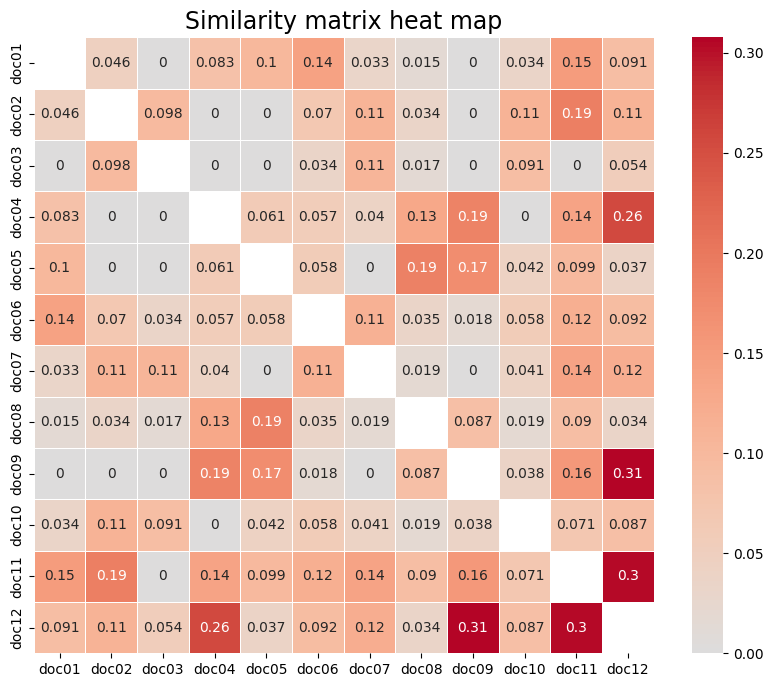

In [ ]:
plt.figure(figsize=(10, 8))

num_docs = len(similarity_matrix)
doc_labels = [f"doc{str(i).zfill(2)}" for i in range(1, num_docs + 1)]

mask = np.isclose(similarity_matrix, 1)

sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', 
            cbar=True, linewidths=0.5, xticklabels=doc_labels, yticklabels=doc_labels, 
            mask=mask, center=0) 

plt.title('Similarity matrix heat map', fontsize=17)

plt.show()

### Analysis of the similarity matrix:

As can be seen in the matrix above, documents doc09 and doc12 present the highest similarity (0.31). This suggests that they probably share many words or have a common theme, the same is true to a lesser extent for documents doc11 and doc12 which have an equally high similarity (0.3).

On the other hand, there are multiple cells with values close to 0, indicating that some documents share practically no vocabulary in common.

The observed trend suggests that the most similar documents probably deal with related topics or even combine the two main topics (mobile technology and electric vehicles). Meanwhile, documents with lower similarity seem to focus on different topics.

## 6. (Optional) TF-IDF:

- Calculate the TF-IDF vectors of the documents.
- Calculate the cosine similarity between documents using the TF-IDF vectors and compare the results with the BoW model.

In [29]:
documents_text = [" ".join(doc) for doc in documents]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_text)

# Cosine similarity between all pairs of documents.
tfidf_similarity_matrix = cosine_similarity(tfidf_matrix)

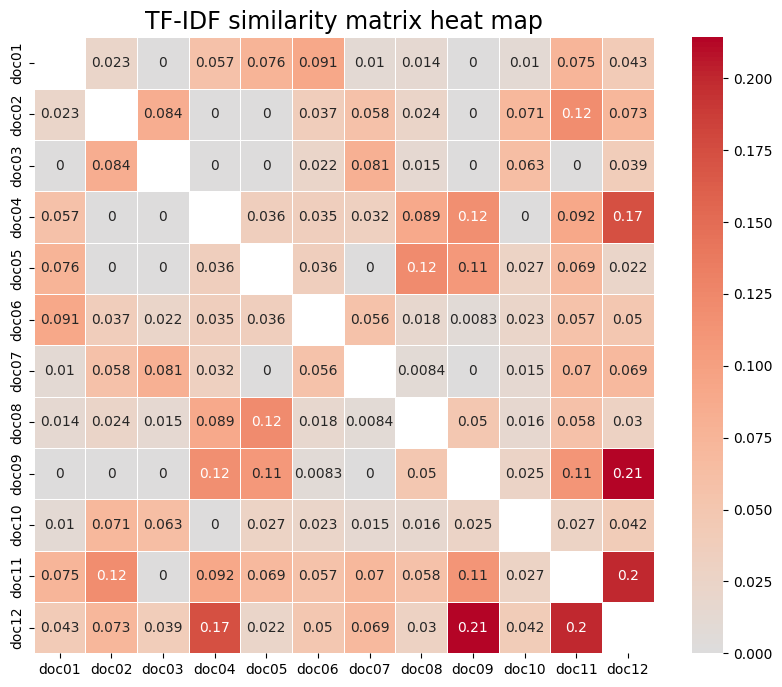

In [30]:
plt.figure(figsize=(10, 8))

mask = np.isclose(similarity_matrix, 1)

sns.heatmap(tfidf_similarity_matrix, annot=True, cmap='coolwarm', mask=mask,
            cbar=True, linewidths=0.5, xticklabels=doc_labels, yticklabels=doc_labels, center=0)

plt.title('TF-IDF similarity matrix heat map', fontsize=17)

plt.show()

As we can see, the results obtained using the TF-IDF vectors coincide with those obtained using the BoW model, with documents doc09 and doc12 being the most similar, followed by doc12 and doc11.

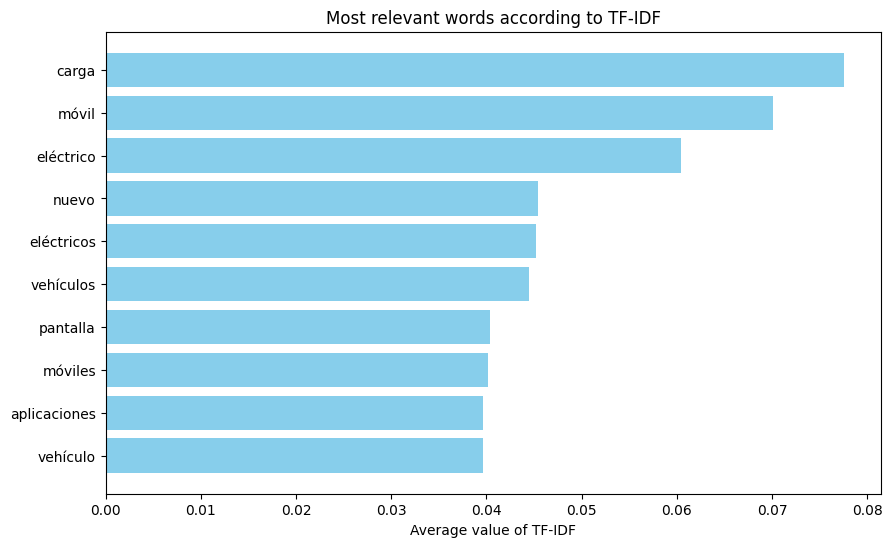

In [31]:
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_scores = tfidf_matrix.mean(axis=0).A1
tfidf_top_indices = tfidf_scores.argsort()[::-1][:10]
top_terms = [(feature_names[i], tfidf_scores[i]) for i in tfidf_top_indices]

terms, scores = zip(*top_terms)
plt.figure(figsize=(10, 6))
plt.barh(terms, scores, color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most relevant words according to TF-IDF')
plt.xlabel('Average value of TF-IDF')
plt.show()


Here we can see that according to TF-IDF the 10 most relevant words in the documents are related to the topics of technology and automobiles.